<p>How is Seq2Seq better than RNN?</p>

<p>In this model, an encoder accepts the actual text and summary, trains the model to create an encoded representation, and sends it to a decoder which decodes the encoded representation into a reliable summary.</p>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
summary = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/News Summary/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/News Summary/news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
print(summary.head())
print("Summary shape:", summary.shape)

               author                  date  \
0        Chhavi Tyagi  03 Aug 2017,Thursday   
1         Daisy Mowke  03 Aug 2017,Thursday   
2      Arshiya Chopra  03 Aug 2017,Thursday   
3       Sumedha Sehra  03 Aug 2017,Thursday   
4  Aarushi Maheshwari  03 Aug 2017,Thursday   

                                           headlines  \
0  Daman & Diu revokes mandatory Rakshabandhan in...   
1  Malaika slams user who trolled her for 'divorc...   
2  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Hotel staff to get training to spot signs of s...   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujana-...   
4  http://indiatoday.intoday.in/story/sex-traffic...   

                                           

In [ ]:
df1 = raw.iloc[: ,0:2].copy()
df2 = summary.iloc[: ,0:6].copy()

# Extract columns from df2, create a new col called text and concatenate values with " " as separation
df2['text'] = df2['author'].str.cat(df2['date'].str.cat(df2['read_more'].str.cat(df2['text'].str.cat(df2['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

df = pd.DataFrame()
df['text'] = pd.concat([df1['text'], df2['text']], ignore_index=True)
df['summary'] = pd.concat([df1['headlines'], df2['headlines']], ignore_index=True)

In [ ]:
print(df.head())
print("DF shape:", df.shape)

                                                text  \
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...   
1  Kunal Shah's credit card bill payment platform...   
2  New Zealand defeated India by 8 wickets in the...   
3  With Aegon Life iTerm Insurance plan, customer...   
4  Speaking about the sexual harassment allegatio...   

                                             summary  
0  upGrad learner switches to career in ML & Al w...  
1  Delhi techie wins free food from Swiggy for on...  
2  New Zealand end Rohit Sharma-led India's 12-ma...  
3  Aegon life iTerm insurance plan helps customer...  
4  Have known Hirani for yrs, what if MeToo claim...  
DF shape: (102915, 2)


How to find all non-alphabetic characters?

In [ ]:
import re

def clean_text(column):

  for row in column:
    row = re.sub("(__+)", " ", str(row)).lower()
    row = re.sub("(--+)", " ", str(row)).lower()
    row = re.sub("(~~+)", " ", str(row)).lower()
    row = re.sub("(\+\++)", " ", str(row)).lower()
    row = re.sub("(\.\.+)", " ", str(row)).lower()

    # Remove the characters - <>()|&©ø"',;?~*!
    row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()
    row = re.sub("(mailto:)", " ", str(row)).lower()
    row = re.sub(r"(\\x9\d)", " ", str(row)).lower()
    row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()
    row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

    # Remove punctuations at the end of a word
    row = re.sub("(\.\s+)", " ", str(row)).lower()
    row = re.sub("(\-\s+)", " ", str(row)).lower()
    row = re.sub("(\:\s+)", " ", str(row)).lower()

    try:
      url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
      repl_url = url.group(3)
      row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
    except:
      pass

    row = re.sub("(\s+)", " ", str(row)).lower()
    row = re.sub("(\s+.\s+)", " ", str(row)).lower()

    yield row

In [ ]:
processed_text = clean_text(df['text'][:50000])
processed_summary = clean_text(df['summary'][:50000])

In [ ]:
# pipe() method provided by spacy ensures that everything is string data type
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
# Process the text in batches since when processing texts one by one, each text
# requires the NLP pipeline to be initialized, executed, and finalized separately

In [ ]:
text = []
for i, doc in enumerate(nlp.pipe(processed_text, batch_size=6000)):
  text.append(str(doc))
  if (i + 1) % 6000 == 0:
    print(f'Processed {i + 1} sentences.')

print(len(text))

Processed 6000 sentences.
Processed 12000 sentences.
Processed 18000 sentences.
Processed 24000 sentences.
Processed 30000 sentences.
Processed 36000 sentences.
Processed 42000 sentences.
Processed 48000 sentences.
50000


In [ ]:
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]
print(len(summary))

50000


In [ ]:
df_processed = pd.DataFrame()

df_processed['cleaned_text'] = pd.Series(text)
df_processed['cleaned_summary'] = pd.Series(summary)

print(df_processed['cleaned_summary'].shape)
print(df_processed['cleaned_text'].shape)

(50000,)
(50000,)


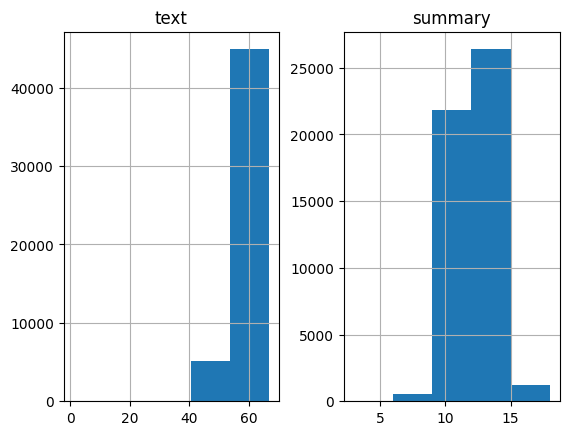

In [ ]:
# Plot to determine the range of length of words where the maximum number of texts and summaries fall into
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for row in df_processed['cleaned_text']:
  text_count.append(len(row.split()))

for row in df_processed['cleaned_summary']:
  summary_count.append(len(row.split()))

graph = pd.DataFrame()
graph['text'] = text_count
graph['summary'] = summary_count

graph.hist(bins=5)
plt.show()

In [ ]:
# To find the range for text, consider a random range and check how many words fall into it
count = 0
for row in df_processed['cleaned_text']:
  if len(row.split()) < 70:
    count += 1

print(count/len(df_processed['cleaned_text']))

1.0


In [ ]:
max_text_len = 70
max_summary_len = 15

What if I dont want to define the max length, and let the model decide on its own?

In [ ]:
# Select the summaries and text which fall below the max length
import numpy as np

cleaned_text = np.array(df_processed['cleaned_text'])
cleaned_summary = np.array(df_processed['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
  if len(cleaned_text[i].split()) <= max_text_len and len(cleaned_summary[i].split()) <= max_summary_len:
    short_text.append(cleaned_text[i])
    short_summary.append(cleaned_summary[i])

processed_df = pd.DataFrame()
processed_df['text'] = short_text
processed_df['summary'] = short_summary

processed_df.head(5)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...
2,new zealand defeated india by wickets in the f...,_START_ new zealand end rohit sharma-led india...
3,with aegon life iterm insurance plan customers...,_START_ aegon life iterm insurance plan helps ...
4,speaking about the sexual harassment allegatio...,_START_ have known hirani for yrs what if meto...


In [ ]:
# Both sostok and eostok along with START and END are added to make a unique
# combination to identify start and end of summary

processed_df['summary'] = processed_df['summary'].apply(lambda x: 'sostok ' + x + ' eostok')
processed_df.head(5)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...
2,new zealand defeated india by wickets in the f...,sostok _START_ new zealand end rohit sharma-le...
3,with aegon life iterm insurance plan customers...,sostok _START_ aegon life iterm insurance plan...
4,speaking about the sexual harassment allegatio...,sostok _START_ have known hirani for yrs what ...


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(np.array(processed_df["text"]), np.array(processed_df["summary"]), test_size=0.1, random_state=0, shuffle=True)

In [ ]:
# Token sentences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

In [ ]:
# Find rare words in the text and their percentage
threshhold = 5

count = 0
total_count = 0

for key, value in X_tokenizer.word_counts.items():
  total_count += value
  if value < threshhold:
    count += value

print("Percentage of rare words: ", count/total_count*100)

Percentage of rare words:  2.354162456345279


In [ ]:
# Tokenize again by not considering rare words
X_tokenizer = Tokenizer(num_words = total_count - count)
X_tokenizer.fit_on_texts(list(X_train))

# Convert text to integers
X_train_sequence = X_tokenizer.texts_to_sequences(X_train)
X_validation_sequence = X_tokenizer.texts_to_sequences(X_validation)

# Padding
X_train = pad_sequences(X_train_sequence,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(X_validation_sequence, maxlen=max_text_len, padding='post')

X_vocabulary = X_tokenizer.num_words + 1

print("Size of vocabulary: ", X_vocabulary)

Size of vocabulary:  2546291


In [ ]:
Y_tokenizer = Tokenizer()
Y_tokenizer.fit_on_texts(list(Y_train))

In [ ]:
threshhold = 5

count = 0
total_count = 0

for key, value in Y_tokenizer.word_counts.items():
  total_count += value
  if value < threshhold:
    count += value

print("Percentage of rare words: ", count/total_count*100)

Percentage of rare words:  4.6013316987572415


In [ ]:
Y_tokenizer = Tokenizer(num_words=total_count-count)
Y_tokenizer.fit_on_texts(list(Y_train))

# Convert text sequences to integer sequences
Y_train_seqeunce = Y_tokenizer.texts_to_sequences(Y_train)
Y_validation_sequence = Y_tokenizer.texts_to_sequences(Y_validation)

# Pad zero upto maximum length
y_train = pad_sequences(Y_train_seqeunce, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(Y_validation_sequence, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
Y_vocabulary = Y_tokenizer.num_words + 1

print("Size of vocabulary: ", Y_vocabulary)

Size of vocabulary:  595303


<h5>Define Model</h5>

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(X_vocabulary, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(Y_vocabulary, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(Y_vocabulary, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 70)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 70, 200)              5092582   ['input_1[0][0]']             
                                                          00                                      
                                                                                                  
 lstm (LSTM)                 [(None, 70, 300),            601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                    

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [X_train, Y_train[:, :-1]],
    Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

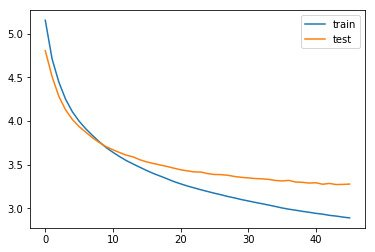

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
for i in range(0, 19):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           max_text_len)))
    print '\n'

Few Summaries

# Output
Review: us president donald trump on wednesday said that north korea has returned the remains of 200 us troops missing from the korean war although there was no official confirmation from military authorities north korean leader kim jong un had agreed to return the remains during his summit with trump about 700 us troops remain unaccounted from the 1950 1953 korean war
Original summary: start n korea has returned remains of 200 us war dead trump end
Predicted summary:  start n korea has lost an war against us trump end

Review: pope francis has said that history will judge those who refuse to accept the science of climate change if someone is doubtful that climate change is true they should ask scientists the pope added notably us president donald trump who believes global warming is chinese conspiracy withdrew the country from the paris climate agreement
Original summary: start history will judge those denying climate change pope end
Predicted summary:  start pope francis will be in paris climate deal prez end

Review: the enforcement directorate ed has attached assets worth over ã¢ââ¹33 500 crore in the over three year tenure of its chief karnal singh who retires sunday officials said the agency filed around 390 in connection with its money laundering probes during the period the government on saturday appointed indian revenue service irs officer sanjay kumar mishra as interim ed chief
Original summary: start enforcement attached assets worth ã¢ââ¹33 500 cr in yrs end
Predicted summary:  start ed attaches assets worth 100 crore in india in days end